In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='123456',
    database='eCommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/Ultimate Programming/PortFolio ProJect/E Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db = mysql.connector.connect(host = 'localhost',
                              user = 'root',
                              password = '123456',
                              database = 'eCommerce')
cur = db.cursor()

# 1. List all unique cities where customers are located.

In [2]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = ['Customers_City']
print(df.head(19))

           Customers_City
0                  franca
1   sao bernardo do campo
2               sao paulo
3         mogi das cruzes
4                campinas
5          jaragua do sul
6                 timoteo
7                curitiba
8          belo horizonte
9           montes claros
10         rio de janeiro
11       lencois paulista
12          caxias do sul
13             piracicaba
14              guarulhos
15                 pacaja
16          florianopolis
17   aparecida de goiania
18            santo andre


# 2. Count The Number Of Orders Placed In 2017.

In [3]:
que2 = """ select count(order_id) from orders
    where year(order_purchase_timestamp) = 2017"""
cur.execute(que2)
data = cur.fetchall()
df = pd.DataFrame(data)
df.columns = ['Count']
print(df)

   Count
0  45101


# 3. Find the total sales per category.

In [4]:
que3 = """ select products.product_category, round(sum(payments.payment_value),2)
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category"""
cur.execute(que3)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Categorty', 'Sales'])
print(df.head(10))

              Categorty       Sales
0             perfumery   506738.66
1  Furniture Decoration  1430176.39
2             telephony   486882.05
3        bed table bath  1712553.67
4            automotive   852294.33
5  computer accessories  1585330.45
6            housewares  1094758.13
7                babies   539845.66
8                  toys   619037.69
9      Furniture office   646826.49


# 4. Calculate the percentage of orders that were paid in installments.

In [5]:
q4 = """  select (sum(case when payment_installments >=1 then 1 
    else 0 end))/ count(*) *  100 from payments"""
cur.execute(q4)
data = cur.fetchall()
df = pd.DataFrame(data)
'Total Paid Installmenys is : ' ,data[0][0]

('Total Paid Installmenys is : ', Decimal('99.9981'))

# 5. Count the number of customers from each state. 


  State  Numbers
0    SP    41746
1    SC     3637
2    MG    11635
3    PR     5045
4    RJ    12852
5    RS     5466
6    PA      975
7    GO     2020
8    ES     2033
9    BA     3380


C:\Users\iamaf\AppData\Local\Temp\ipykernel_8128\493020383.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'State', y ='Numbers', palette='viridis')


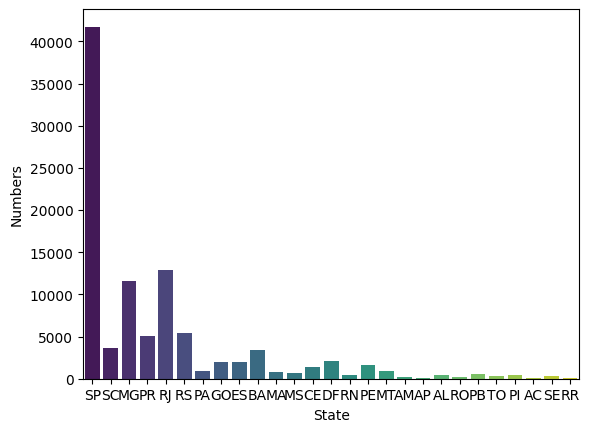

In [6]:
q5 = """select customer_state, count(customer_id) from customers
group by customer_state"""
cur.execute(q5)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['State', 'Numbers'])
print(df.head(10))
sns.barplot(data = df, x = 'State', y ='Numbers', palette='viridis')
plt.show()

# 6.Calculate the number of orders per month in 2018.

  Month  Order_Num
0   Jul       6292
1   Aug       6512
2   Feb       6728
3   Jun       6167
4   Mar       7211
5   Jan       7269
6   May       6873
7   Apr       6939
8   Sep         16
9   Oct          4


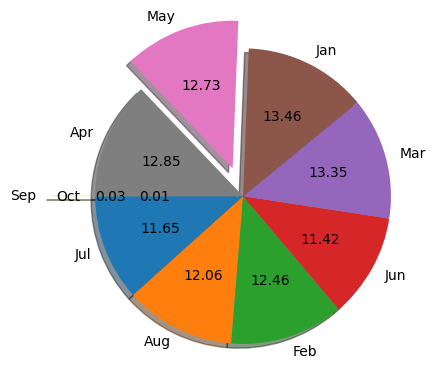

In [7]:
import calendar
q6 = """ select monthname(order_purchase_timestamp), count(order_id) from ecommerce.orders
where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp)"""
cur.execute(q6)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Month', 'Order_Num'])
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[list(calendar.month_name).index(x)])
print(df)
ex = [0,0,0,0,0,0,0.2,0, 0.3, 0]
plt.pie(df['Order_Num'], labels = df['Month'], startangle=180, explode = ex, shadow = True, autopct = "%.2f")
plt.show()

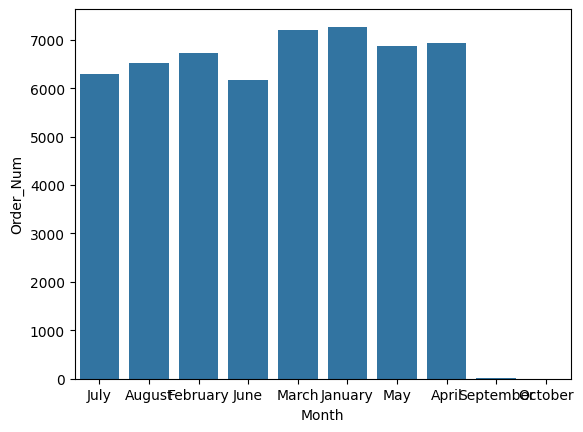

In [8]:
q6 = """ select monthname(order_purchase_timestamp), count(order_id) from ecommerce.orders
where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp)"""
cur.execute(q6)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Month', 'Order_Num'])
sns.barplot(data = df, x = 'Month', y = 'Order_Num',)
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [9]:
query = """ with count_pr_ord as (select orders.order_id, orders.customer_id , count(order_items.order_item_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_pr_ord.oc),1)
from customers join count_pr_ord
on customers.customer_id = count_pr_ord.customer_id
group by customers.customer_city """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer_city', 'avg_order'])

# 3. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """select products.product_category, round(((round(sum(payments.payment_value),2))/(select sum(payments.payment_value) from payments) * 100),2)
from products join order_items
on products.product_id= order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by products.product_category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['prod_ctegory', 'percentage'])
print(df)

                   prod_ctegory  percentage
0                     perfumery        3.17
1          Furniture Decoration        8.93
2                     telephony        3.04
3                bed table bath       10.70
4                    automotive        5.32
..                          ...         ...
69               cds music dvds        0.01
70                   La Cuisine        0.02
71  Fashion Children's Clothing        0.00
72                     PC Gamer        0.01
73       insurance and services        0.00

[74 rows x 2 columns]


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query = """select products.product_category, count(order_items.product_id), round(avg(order_items.price))
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Products_cat', 'total_cnt', 'avg_price'])
np.corrcoef(df['total_cnt'], df['avg_price'])

array([[ 1.       , -0.1064395],
       [-0.1064395,  1.       ]])

# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [12]:
query = """ select  * , dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, round(sum( payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['seller_id', 'revenue', 'rank'])
df.head(10)

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


# 1. Calculate the moving average of order values for each customer over their order history.

In [13]:
query = """select customer_id, order_purchase_timestamp, avg(pay)
over (partition by customer_id order by order_purchase_timestamp rows
between 2 preceding and current row) as moving_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as pay
from orders join payments
on orders.order_id = payments.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1,2
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.709961


# 2. Calculate the cumulative sales per month for each year.

In [14]:
query = """select years, months, sum(total_payment)
over(order by years, months) pay from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) total_payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months) as a
order by years asc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['years','month', 'cus_sum'])
print(df)

    years      month      cus_sum
0    2016   December        19.62
1    2016    October     59110.10
2    2016  September     59362.34
3    2017      April    477150.37
4    2017     August   1151546.69
5    2017   December   2029948.17
6    2017   February   2321856.18
7    2017    January   2460344.22
8    2017       July   3052727.14
9    2017       June   3564003.52
10   2017      March   4013867.12
11   2017        May   4606785.94
12   2017   November   5801668.74
13   2017    October   6581346.62
14   2017  September   7309109.07
15   2018      April   8469894.55
16   2018     August   9492319.87
17   2018   February  10484783.21
18   2018    January  11599787.39
19   2018       July  12666328.14
20   2018       June  13690208.64
21   2018      March  14849860.76
22   2018        May  16003842.91
23   2018    October  16004432.58
24   2018  September  16008872.12


# 3. Calculate the year-over-year growth rate of total sales.

   years  total_payment   growth
0   2016       59362.34      NaN
1   2017     7249746.73  12112.7
2   2018     8699763.05     20.0


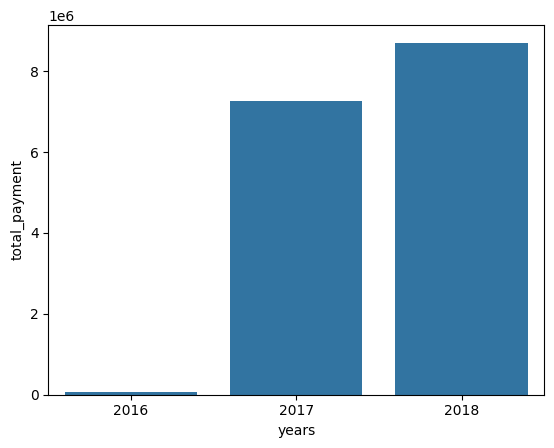

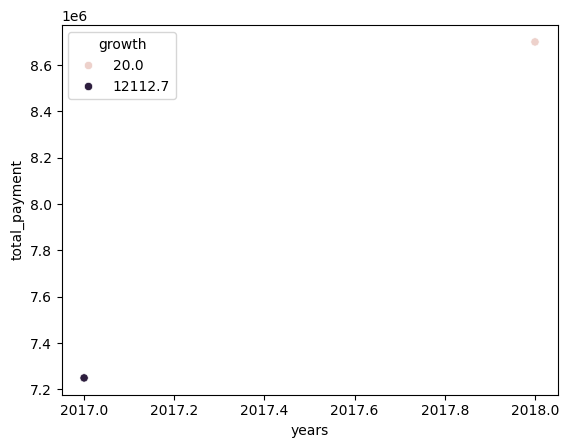

In [26]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2) as pay
from orders join payments
on orders.order_id = payments.order_id
group by years)
select years, pay, round(((pay - lag(pay, 1) over(order by years)) / lag(pay, 1) over(order by years)) * 100,2) from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['years', 'total_payment', 'growth'])
print(df)
sns.barplot(data = df, x = 'years', y = 'total_payment')
plt.show()
sns.scatterplot(data = df, x = 'years', y = 'total_payment', hue = 'growth')
plt.show()

# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [27]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
print(df)

      0
0  None


# Identify the top 3 customers who spent the most money in each year.

In [29]:
query = """select years, customer_id, round(payment,2), d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
print(df)

   years                                id   payment  rank
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.55     1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.74     2
2   2016  4a06381959b6670756de02e07b83815f   1227.78     3
3   2017  1617b1357756262bfa56ab541c47bc16  13664.08     1
4   2017  c6e2731c5b391845f6800c97401a43a9   6929.31     2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6   6726.66     3
6   2018  ec5b2ba62e574342386871631fafd3fc   7274.88     1
7   2018  f48d464a0baaea338cb25f816991ab1f   6922.21     2
8   2018  e0a2412720e9ea4f26c1ac985f6a7358   4809.44     3
